In [1]:
!pip install transformers==4.2.0
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 1.8 MB 1.2 MB/s eta 0:00:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.2.2
    Uninstalling transformers-4.2.2:
      Successfully uninstalled transformers-4.2.2


In [2]:
from transformers import BertForSequenceClassification, DistilBertTokenizerFast, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time
import pickle

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [4]:
def read_train_and_test(train_path, test_path): #path: path of the whole dataset
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test

train_path = "../input/data-remove-cluster-5/train_cluster_5.csv"
test_path = "../input/data-remove-cluster-5/test_cluster_5.csv"
train_csv, test_csv = read_train_and_test(train_path, test_path)

In [5]:
train_labels = list(train_csv.label.values)
print(train_labels.count(0))
print(train_labels.count(1))
print(train_labels.count(2))

1136
15369
3321


In [6]:
print(train_csv.tweet.values[:10])

['# anywere & # 8220 ; @ TheCooleyShow : LA = palm trees and great weather Any were else = horrible weather and no <SWEAR-1> & # 8221 ;'
 'RT @ OfficialA1King : The face you make when you see a <SWEAR-2> trying to preach on twitter http : //t.co/2T1UkUDQBw'
 '<SWEAR-1> get off my twitter <SWEAR-2> & # 128074 ;'
 'I can taste loud n <SWEAR-2> on my <SWEAR-2> & # 128541 ;'
 'Diabetes galore & # 128514 ; & # 128514 ; & # 128514 ; & # 128514 ; & # 128514 ; RT @ TIME : Colorado health officials recommend <SWEAR-1> brownie ban http : //t.co/Z59oy20TMp'
 '@ LaneBelgarde @ A7XDemery you <SWEAR-1> <SWEAR-1> didnt even invite me'
 'RT @ djMemphis10 : Never hurt your Girlfriend to make a <SWEAR-2> happy & # 128175 ; # djmemphis10'
 'This is why nothing gets done . <SWEAR-3> like Coburn trying 2 ad a <SWEAR-1> amendment 2 a public works bill . Push back on the # teabagger # morningjoe'
 'RT @ ccancel14 : Miserable <SWEAR-1> talk the most <SWEAR-1> & # 128514 ; & # 9996 ; & # 65039 ;'
 'Its gorg ou

In [5]:
def run_tokenizer(train_csv, test_csv, merge_label=False, add_token=False):
    tokenizer = DistilBertTokenizerFast.from_pretrained('bert-base-uncased') 
    if add_token:
      tokenizer.add_tokens(add_token)

    def get_max_len(tokenizer, train_csv):
        tweets = train_csv.tweet.values
        max_length = 0
        for t in tweets:
          ids = tokenizer.encode(t)
          max_length = max(len(ids),max_length)
        return max_length

    max_length = get_max_len(tokenizer, train_csv)
    train_tweets, train_labels = train_csv.tweet.values, train_csv.label.values
    test_tweets, test_labels = test_csv.tweet.values, test_csv.label.values
    if merge_label == True:
       train_labels = [l if l ==0 else 1 for l in train_labels]
       test_labels = [l if l ==0 else 1 for l in test_labels]

    def tokenize_for_tweet(tokenizer, tweets, labels):
        input_ids = []
        attention_masks = []

        for t in tweets:
            input_dict = tokenizer.encode_plus(t, add_special_tokens=True, max_length=max_length, truncation=True, padding='max_length',return_tensors='pt')
            input_ids.append(input_dict['input_ids'])
            attention_masks.append(input_dict['attention_mask'])
        input_ids = torch.cat(input_ids,dim=0)
        attention_masks = torch.cat(attention_masks,dim=0)
        labels=torch.tensor(labels)
        dataset = TensorDataset(input_ids, attention_masks, labels)
        return dataset
        
    train_dataset = tokenize_for_tweet(tokenizer, train_tweets, train_labels)
    test_dataset = tokenize_for_tweet(tokenizer, test_tweets, test_labels)
    num_label = 3 if merge_label == False else 2
    return train_dataset, test_dataset, num_label, tokenizer

tokens = ['<SWEAR-0>', '<SWEAR-1>', '<SWEAR-2>','<SWEAR-3>','<SWEAR-4>']
train_dataset, test_dataset, num_label, tokenizer = run_tokenizer(train_csv, test_csv, merge_label = False,add_token = tokens)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [6]:
batch_size = 10

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)

test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = batch_size)

In [8]:
bert_model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = num_label)
bert_model.resize_token_embeddings(len(tokenizer))
bert_model = bert_model.to(DEVICE)

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.

In [7]:
def evaluate(model, best_acc, test_dataloader):
    num_total, num_correct = 0, 0
    model.train(False)
    with torch.no_grad():
      eval_loss = 0

      for input, mask, label in test_dataloader:
          model.zero_grad()
          
          input = input.to(DEVICE)
          mask = mask.to(DEVICE)
          label = label.to(DEVICE)

          loss, output = model(input_ids=input, attention_mask=mask, labels=label, return_dict=False)

          predict_label = torch.argmax(output, dim=1)

          num_correct += (predict_label == label).sum().item()
          num_total += len(label)

          eval_loss += loss.item()

      acc = num_correct/num_total
      if acc > best_acc:
        best_acc = acc
        torch.save(model, 'model_remove_cluster_5')

    print('eval_loss: {}, accuracy: {}'.format(eval_loss,acc))
    return best_acc


In [8]:
def training(model, epochs, optimizer, train_dataloader, test_dataloader, scheduler=None):
    best_acc = 0
    for e in range(epochs):
        print('training {} epoch...'.format(e+1))
        start_time = time.time()

        train_loss =0

        model.train(True)
        for input, mask, label in train_dataloader:
            input = input.to(DEVICE)
            mask = mask.to(DEVICE)
            label=label.to(DEVICE)
            
            model.zero_grad()

            loss, output = model(input_ids=input, attention_mask=mask, labels=label,return_dict=False)

            train_loss += loss.item()
            loss.backward()

            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
            optimizer.step()

            if scheduler:
              scheduler.step()

        sec = time.time()-start_time
        print('{} seconds used......'.format(sec))
        print("{} training finished! train loss: {}".format(e+1,train_loss))
        print('evaluating...')
        best_acc = evaluate(model, best_acc, test_dataloader)

In [9]:
optimizer = AdamW(bert_model.parameters(),lr = 2e-5, eps = 1e-8)

NameError: name 'bert_model' is not defined

In [13]:
epochs = 10

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
training(bert_model, epochs, optimizer, train_dataloader, test_dataloader)

In [10]:
def predicting_labels(model, test_dataloader):
    true_labels, predict_labels = [], []
    for input, mask, label in test_dataloader:
        model.zero_grad()
        input=input.to(DEVICE)
        mask=mask.to(DEVICE)
        label=label.to(DEVICE)
        loss, logits = model(input_ids=input, attention_mask=mask, labels=label, return_dict=False)
        predict_label = torch.argmax(logits, dim=1)
        true_labels+=(label.tolist())
        predict_labels+=(predict_label.tolist())
    return true_labels, predict_labels

In [ ]:
model = torch.load('../input/remove-tags-3class/model0.8791607827314908')
true_labels, predict_labels = predicting_labels(model, test_dataloader)

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
import numpy as np
import random

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
cm = confusion_matrix(true_labels, predict_labels)
plot_confusion_matrix(true_labels, predict_labels, classes=['hate','offensive','neither'] ,title='Confusion matrix without rebalance')

#Plot normalized confusion matrix
plot_confusion_matrix(true_labels, predict_labels, classes=['hate','offensive','neither'], normalize=True,title='Normalized confusion matrix without rebalance')

plt.show()

print(classification_report(true_labels, predict_labels, target_names=['hate','offensive','neither']))

In [13]:
def rebalance_dataset(dataset):
    #dataset = sorted(dataset, key=lambda x:x[2])
    data_0 = [inst for inst in dataset if inst[2]==0]
    data_1 = [inst for inst in dataset if inst[2]==1]
    data_2 = [inst for inst in dataset if inst[2]==2]
    random.shuffle(data_0)
    random.shuffle(data_1)
    random.shuffle(data_2)
    num_data0 = len(data_0)
    
    #num_label_2 = len([inst for inst in dataset if inst[2]==2])
    #num_label_1 = len([inst for inst in dataset if inst[2]==1])
    #num_label_0 = len([inst for inst in dataset if inst[2]==0]) 
    #balanced_dataset = dataset[:num_label_0] + dataset[num_label_1:num_label_0 + num_label_1] + dataset[num_label_0 + num_label_1: num_label_0 + num_label_1 + num_label_0]
    balanced_dataset = data_0+data_1[:num_data0]+data_2[:num_data0]
    return balanced_dataset

In [14]:
re_train_dataset = rebalance_dataset(train_dataset)
re_test_dataset = rebalance_dataset(test_dataset)

In [15]:
batch_size = 10

In [16]:
re_train_dataloader = DataLoader(re_train_dataset, sampler = RandomSampler(re_train_dataset), batch_size = batch_size)
re_test_dataloader = DataLoader(re_test_dataset, sampler = RandomSampler(re_test_dataset), batch_size = batch_size)

In [21]:
epochs = 20
training(bert_model, epochs, optimizer, re_train_dataloader, re_test_dataloader)

training 1 epoch...
188.37396121025085 seconds used......
1 training finished! train loss: 323.8547939360142
evaluating...
eval_loss: 75.07728391885757, accuracy: 0.5634920634920635
training 2 epoch...
187.7060203552246 seconds used......
2 training finished! train loss: 292.7366193532944
evaluating...
eval_loss: 73.80493628978729, accuracy: 0.5589569160997733
training 3 epoch...
187.4737992286682 seconds used......
3 training finished! train loss: 272.68282157182693
evaluating...
eval_loss: 75.06672585010529, accuracy: 0.590702947845805
training 4 epoch...
187.62920784950256 seconds used......
4 training finished! train loss: 248.99959701299667
evaluating...
eval_loss: 68.15628099441528, accuracy: 0.6473922902494331
training 5 epoch...
187.47837591171265 seconds used......
5 training finished! train loss: 203.6116728335619
evaluating...
eval_loss: 76.08865167200565, accuracy: 0.6768707482993197
training 6 epoch...
187.4755663871765 seconds used......
6 training finished! train loss: 1

KeyboardInterrupt: 

In [17]:
model2 = torch.load('../input/model-remove-5-cluster/model_remove_cluster_5')
true_labels2, predict_labels2 = predicting_labels(model2, re_test_dataloader)

Confusion matrix, without normalization
[[209  40  45]
 [ 96 134  64]
 [ 27  20 247]]
Normalized confusion matrix
[[0.71088435 0.13605442 0.15306122]
 [0.32653061 0.45578231 0.21768707]
 [0.09183673 0.06802721 0.84013605]]


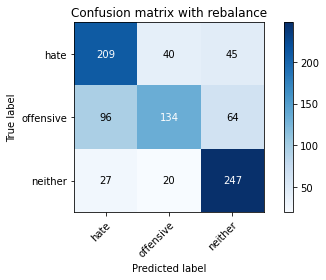

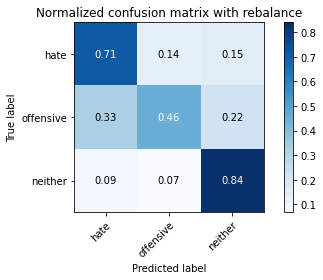

              precision    recall  f1-score   support

        hate       0.63      0.71      0.67       294
   offensive       0.69      0.46      0.55       294
     neither       0.69      0.84      0.76       294

    accuracy                           0.67       882
   macro avg       0.67      0.67      0.66       882
weighted avg       0.67      0.67      0.66       882



In [18]:
cm = confusion_matrix(true_labels2, predict_labels2)
plot_confusion_matrix(true_labels2, predict_labels2, classes=['hate','offensive','neither'] ,title='Confusion matrix with rebalance')

#Plot normalized confusion matrix
plot_confusion_matrix(true_labels2, predict_labels2, classes=['hate','offensive','neither'], normalize=True,title='Normalized confusion matrix with rebalance')

plt.show()

print(classification_report(true_labels2, predict_labels2, target_names=['hate','offensive','neither']))